# Exploratory Data Analysis Part 2: Feature Engineering

In [474]:
import numpy as np
# Libraries importing
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler

from lightgbm import LGBMClassifier
import xgboost as xgb

from utils import model_evaluation


In [475]:
# GLOBAL CONSTANTS
SEED = 1

In [476]:
# Read training data
data = pd.read_csv('./preprocessed_data.csv', index_col=0)

In [477]:
# Take a look on data inside the training dataset
data.head(10)

,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,STATE_OF_BIRTH,NACIONALITY,RESIDENCIAL_STATE,FLAG_RESIDENCIAL_PHONE,...,COMPANY,PROFESSIONAL_STATE,FLAG_PROFESSIONAL_PHONE,PROFESSIONAL_PHONE_AREA_CODE,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,PRODUCT,AGE,TARGET_LABEL_BAD=1
0,,,,,,,,,,,,,,,,,,,,,
1,5,Web,1,F,6.0,1,RN,1,RN,Y,...,N,NO_JOB,N,NO_DATA,0,9.0,4.0,1,32,1
2,15,Carga,1,F,2.0,0,RJ,1,RJ,Y,...,Y,NO_JOB,N,NO_DATA,0,11.0,4.0,1,34,1
3,5,Web,1,F,2.0,0,RN,1,RN,Y,...,N,NO_JOB,N,NO_DATA,0,11.0,NaN,1,27,0
4,20,Web,1,F,2.0,0,PE,1,PE,N,...,N,NO_JOB,N,NO_DATA,0,NaN,NaN,1,61,0
5,10,Web,1,M,2.0,0,RJ,1,RJ,Y,...,N,NO_JOB,N,NO_DATA,0,9.0,5.0,1,48,1
6,10,NaN,1,M,2.0,0,MG,1,MG,Y,...,Y,MG,N,NO_DATA,0,9.0,2.0,2,40,1
7,15,Carga,1,F,2.0,2,BA,1,BA,Y,...,N,NO_JOB,N,NO_DATA,0,11.0,4.0,1,40,1
8,25,Web,1,F,1.0,0,MG,1,SP,N,...,Y,SP,Y,5,0,11.0,2.0,1,28,0
9,15,NaN,1,F,1.0,0,SP,1,SP,Y,...,Y,NO_JOB,N,NO_DATA,0,0.0,2.0,2,31,0


In [478]:
# Read the numerical and categorical features txt files
num_features = []
with open('./numerical_features_names.txt', 'r') as f:
    for line in f:
        # Read line by line and append top empty list
        num_features.append(line.split('\n')[0])

cat_features = []
with open('./categorical_features_names.txt', 'r') as f:
    for line in f:
        # Read line by line and append top empty list
        cat_features.append(line.split('\n')[0])

In [479]:
# Convert dtypes to the right ones
# First use suggested dtypes from pandas core
data = data.convert_dtypes()
# Remove Target variable from features
cat_features.remove('TARGET_LABEL_BAD=1')
# Then use the lists generated before
for col in cat_features:
    # First to string
    data[col] = data[col].astype('string')
    data[col] = pd.Categorical(data[col])

# As Pandas could introduce pd.NA values in some features
# when converting them to categorical, let's replace them with np.nan by casting
# int columns to float32
cols_to_float = data.select_dtypes(include='int').columns
data[cols_to_float] = data[cols_to_float].astype(dtype='float32')

##Dataset Split

In [480]:
# Split data into features and label
X, y = data.drop(columns=['TARGET_LABEL_BAD=1']), data['TARGET_LABEL_BAD=1']
# Split dataset into Train and Test
X_train_0, X_test, y_train_0, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
# Split train datasets into train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_0, y_train_0, test_size=0.2, random_state=SEED
)

In [481]:
## Build processing pipeline
# Create individual transformers
num_transformer = Pipeline(
        steps=[
            ('imputer' , SimpleImputer(strategy='median')),
            ('scaler'  , RobustScaler())
        ]
)

cat_transformer = Pipeline(
        steps=[
            ('imputer2', SimpleImputer(missing_values=pd.NA,
                                      strategy='most_frequent')),
            ('encoder' , OneHotEncoder(drop='if_binary',
                                       #dtype='int8',
                                       handle_unknown='ignore',
                                       sparse=False))
        ]
)

# Ensemble all the transformers
preprocessor = ColumnTransformer(
        transformers=[
            ('num' , num_transformer , num_features),
            ('cat' , cat_transformer , cat_features)
        ]
)

In [482]:
# Use ColumnTransformer 'preprocessor' to process data
# Train data
X_train_pre   = preprocessor.fit_transform(X=X_train)
X_train_0_pre = preprocessor.transform(X=X_train_0)
# Validation data
X_val_pre = preprocessor.transform(X=X_val)
# Test data
X_test_pre = preprocessor.transform(X=X_test)

/home/w/AnyOne_AI/cohort-02-2022/Final_Project/proyecto-final-anyoneai/FP_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 7, 15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/w/AnyOne_AI/cohort-02-2022/Final_Project/proyecto-final-anyoneai/FP_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3, 7, 15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/w/AnyOne_AI/cohort-02-2022/Final_Project/proyecto-final-anyoneai/FP_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [7, 15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Model Selection

### Baseline Model

In [483]:
X_train_pre.shape

(32000, 307)

In [484]:
len(cat_features)+len(num_features)

33

Let's define a Baseline Model to take it as reference.

In [485]:
# Define baseline model
baseline_classifier = RandomForestClassifier(random_state=SEED,
                                             n_jobs=-1,
                                             class_weight='balanced'
                                             )

In [486]:
# Cross Validation
cv_scores = cross_val_score(estimator=baseline_classifier,
                            X=X_train_0_pre,
                            y=y_train_0,
                            cv=5,
                            scoring='recall')

In [487]:
cv_scores

array([0.04116802, 0.04451891, 0.05074198, 0.04930589, 0.0464337 ])

In [488]:
baseline_classifier.fit(X=X_train_pre, y=y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=1)

In [489]:
blm_predict = baseline_classifier.predict(X=X_val_pre)

In [490]:
blm_metrics = model_evaluation.get_performance(predictions=blm_predict,
                                               y_test=y_val)

Model Performance metrics:
------------------------------
Accuracy: 0.7374
Precision: 0.3882
Recall: 0.0484
F1 Score: 0.0861

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.75      0.97      0.85      5956
         1.0       0.39      0.05      0.09      2044

    accuracy                           0.74      8000
   macro avg       0.57      0.51      0.47      8000
weighted avg       0.66      0.74      0.65      8000


Prediction Confusion Matrix:
------------------------------
      0    1
0  5800  156
1  1945   99


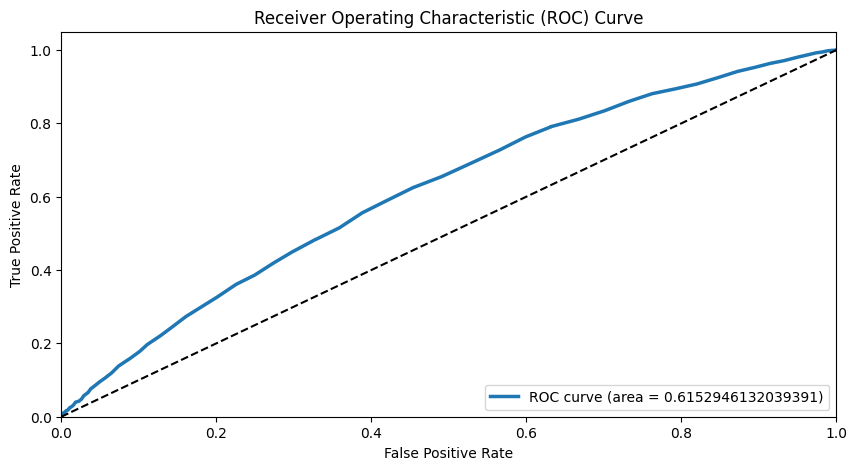

AUC Score of Baseline Model is 0.6153


In [491]:
blm_roc_auc = model_evaluation.plot_roc(model=baseline_classifier,
                                        y_test=y_val,
                                        features=X_val_pre)

print(f'AUC Score of Baseline Model is {round(blm_roc_auc, 4)}')

### Lightgbm

In [492]:
# Try with another classifier
lgb_clf = LGBMClassifier(random_state=SEED, class_weight='balanced')
# Training
lgb_clf.fit(X=X_train_pre, y=y_train)
# Prediction
lgb_pred = lgb_clf.predict(X=X_val_pre)

In [493]:
lgb_metrics = model_evaluation.get_performance(predictions=lgb_pred,
                                               y_test=y_val)

Model Performance metrics:
------------------------------
Accuracy: 0.5948
Precision: 0.3388
Recall: 0.6159
F1 Score: 0.4372

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.82      0.59      0.68      5956
         1.0       0.34      0.62      0.44      2044

    accuracy                           0.59      8000
   macro avg       0.58      0.60      0.56      8000
weighted avg       0.69      0.59      0.62      8000


Prediction Confusion Matrix:
------------------------------
      0     1
0  3499  2457
1   785  1259


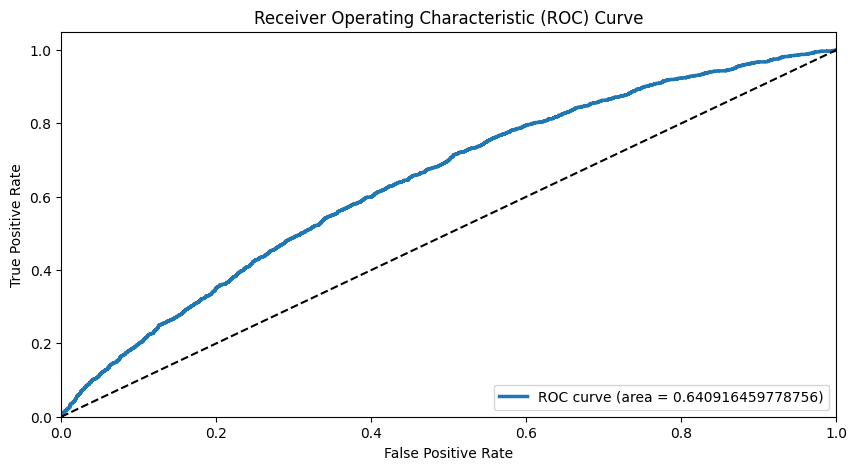

In [494]:
lgb_auc_score = model_evaluation.plot_roc(model=lgb_clf,
                                          y_test=y_val,
                                          features=X_val_pre)

In [495]:
# Hyperparameter Optimization
# Parameters
params = {
    'num_leaves'     : [30, 40, 50, 60, 70, 80, 90, 100],
    #'num_iterations' : [100, 200, 300, 400, 500],
    'learning_rate'  : [0.1, 0.01, 0.001, 0.0001]
}
# Set RandomizedSearchCV
best_lgb_clf = RandomizedSearchCV(estimator=lgb_clf,
                                  param_distributions=params,
                                  scoring='accuracy',
                                  n_iter=20)
# Train
lgb_search = best_lgb_clf.fit(X=X_train_pre, y=y_train)

In [496]:
lgb_search.best_params_

{'num_leaves': 70, 'learning_rate': 0.1}

In [497]:
best_lgb_clf_pred = best_lgb_clf.predict(X=X_val_pre)

In [498]:
best_lgb_clf_metrics = model_evaluation.get_performance(
    predictions=best_lgb_clf_pred, y_test=y_val)

Model Performance metrics:
------------------------------
Accuracy: 0.6142
Precision: 0.3466
Recall: 0.5758
F1 Score: 0.4327

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.81      0.63      0.71      5956
         1.0       0.35      0.58      0.43      2044

    accuracy                           0.61      8000
   macro avg       0.58      0.60      0.57      8000
weighted avg       0.69      0.61      0.64      8000


Prediction Confusion Matrix:
------------------------------
      0     1
0  3737  2219
1   867  1177


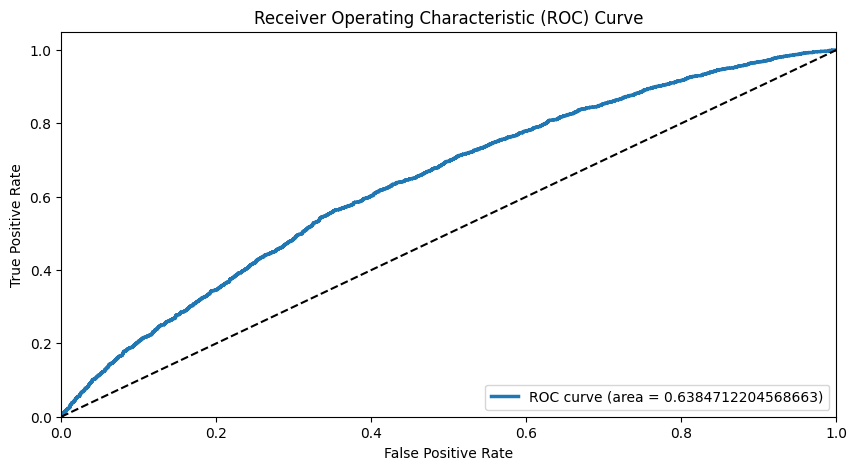

In [502]:
best_lgb_auc_score = model_evaluation.plot_roc(model=best_lgb_clf,
                                               y_test=y_val,
                                               features=X_val_pre)

### XGBoost

In [499]:
# Define model
xgb_clf = xgb.XGBClassifier(tree_method='gpu_hist',
                            max_depth=10,
                            eta=0.5,
                            objective='binary:logistic',
                            gpu_id='0',
                            eval_metric='auc',
                            seed=SEED)
# Train model
xgb_clf.fit(X=X_train_pre, y=y_train)
# Prediction
xgb_pred = xgb_clf.predict(X=X_val_pre)

In [500]:
xgb_metrics = model_evaluation.get_performance(predictions=xgb_pred,
                                               y_test=y_val)

Model Performance metrics:
------------------------------
Accuracy: 0.7148
Precision: 0.3817
Recall: 0.1879
F1 Score: 0.2518

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.76      0.90      0.82      5956
         1.0       0.38      0.19      0.25      2044

    accuracy                           0.71      8000
   macro avg       0.57      0.54      0.54      8000
weighted avg       0.67      0.71      0.68      8000


Prediction Confusion Matrix:
------------------------------
      0    1
0  5334  622
1  1660  384


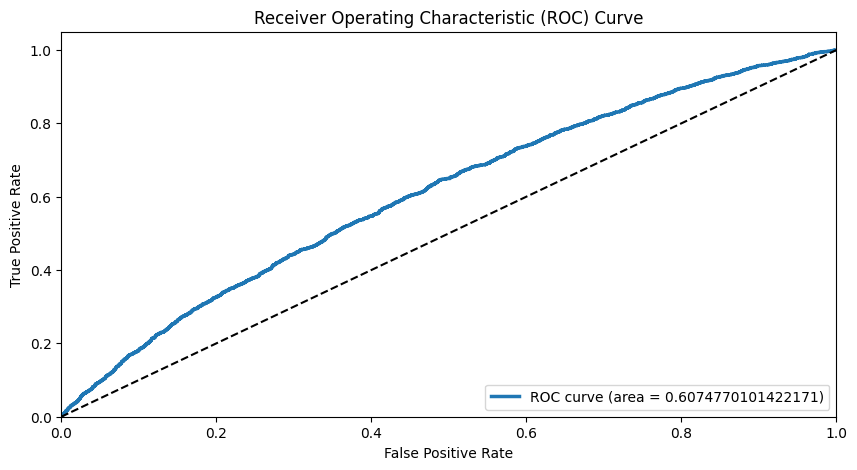

In [501]:
xgb_auc = model_evaluation.plot_roc(model=xgb_clf,
                                    y_test=y_val,
                                    features=X_val_pre)